In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
from spotipy import Spotify
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import altair as alt
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')
# Include an image for each plot since Gradescope only supports displaying plots as images
alt.renderers.enable('mimetype')
# alt.renderers.enable('png')
# alt.renderers.enable('svg')

CLIENT_ID='3580400af5d347dfbe35ae9dbeec6410'
CLIENT_SECRET='d4237f7715a844b8b7f108d8eb9077a1'
user_id = "31hdmjwit53q7bad6kgrbkwu5diq"
auth_manager = SpotifyClientCredentials()
token = auth_manager.get_access_token(as_dict=False)

# sp = Spotify(auth_manager=auth_manager, auth=token)
# sp = Spotify(auth=token)
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id= CLIENT_ID,
                                               client_secret=CLIENT_SECRET,
                                               redirect_uri="http://127.0.0.1:8000",
                                               scope='user-library-read'))


# Import All saved tracks from spotify

In [5]:
sp_saved_tracks = []
offset = 0

tracks = sp.current_user_saved_tracks(limit=None).get('items')

while tracks != []:
    sp_saved_tracks.extend(tracks)
    offset += len(tracks)
    tracks = sp.current_user_saved_tracks(limit=None, offset=offset).get('items')

ConnectionError: HTTPSConnectionPool(host='api.spotify.com', port=443): Max retries exceeded with url: /v1/me/tracks?offset=0 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f1f84bcb6a0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))

# Clustering using audio features

In [ ]:
df = pd.DataFrame(sp.audio_features(tracks=[song['track']['uri'] for song in sp_saved_tracks[:100]]))

for i in range(1, int(np.ceil(len(sp_saved_tracks)/100))):
    df = pd.concat([df, pd.DataFrame(sp.audio_features(tracks=[song['track']['uri'] for song in sp_saved_tracks[i*100 : (i+1)*100]]))])
    
names = pd.DataFrame({
            "uri": [song['track']['uri'] for song in sp_saved_tracks],
            "name": [song['track']['name'] for song in sp_saved_tracks]
        })
df = df.merge(names, how='left', on="uri")
df.drop(columns=["type", 
                 "uri", 
                 "track_href",
                 "analysis_url"], inplace=True)

In [ ]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
X_train.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'id', 'duration_ms', 'time_signature', 'name'],
      dtype='object')

In [3]:
col_transformer = make_column_transformer(
    (StandardScaler(), ['danceability', 
                        'energy',
                        'loudness',
                        'speechiness',
                        'acousticness',
                        'instrumentalness', 
                        'liveness',
                        'valence',
                        'tempo',
                        'duration_ms']),
    (OneHotEncoder(drop="if_binary", handle_unknown="ignore"), ["mode", "key", "time_signature"]),
    remainder="passthrough"
)

X_train_trans = pd.DataFrame(col_transformer.fit_transform(X_train), columns=col_transformer.get_feature_names_out())

NameError: name 'X_train' is not defined

In [38]:
X_train_trans.head()

,standardscaler__danceability,standardscaler__energy,standardscaler__loudness,standardscaler__speechiness,standardscaler__acousticness,standardscaler__instrumentalness,standardscaler__liveness,standardscaler__valence,standardscaler__tempo,standardscaler__duration_ms,...,onehotencoder__key_9,onehotencoder__key_10,onehotencoder__key_11,onehotencoder__time_signature_0,onehotencoder__time_signature_1,onehotencoder__time_signature_3,onehotencoder__time_signature_4,onehotencoder__time_signature_5,remainder__id,remainder__name
0,-1.930392,-0.423656,-0.162903,-0.739119,2.049768,-0.299708,-0.683457,0.232977,-1.209839,-0.292033,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go
1,1.660165,-0.458442,-0.779551,1.009207,-0.753555,-0.299708,-0.003673,-0.106457,-0.069763,1.502762,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2jt2WxXMCD4zjACthkJQVE,The Ringer
2,-0.490461,-1.438236,-1.396556,-0.515303,-0.487959,-0.299708,-0.620687,1.567781,2.498461,-1.078315,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1TEL1pw1ikqzYhbIpPZbsz,Freaky Girl
3,0.467433,0.231472,0.667146,-0.736105,-0.712597,0.815967,-0.397654,0.852216,0.150162,0.09358,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,74tsW4h0WDYRpfD19gc10W,Faded - ODESZA Remix
4,-1.275316,0.956172,-0.829868,-0.485913,-0.676705,-0.285676,1.378598,0.774238,1.295885,-0.42259,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,63T7DJ1AFDD6Bn8VzG6JE8,"Paint It, Black"


# Selecting value of K for clustering

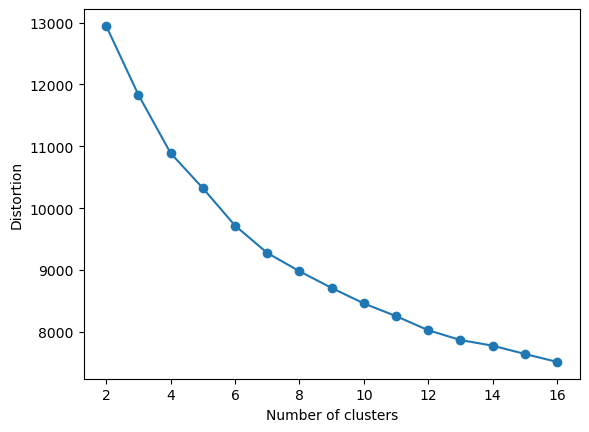

In [40]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil = []
kmax = 16

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
# for k in range(2, kmax+1):
#     km = KMeans(
#             n_clusters=k, init='random',
#             n_init=10, max_iter=5000, 
#             tol=1e-04, random_state=42
#         )
#     km.fit(X_train_trans.drop(["remainder__id", "remainder__name"], axis=1))
#     labels = km.labels_
#     sil.append(silhouette_score(X_train_trans.drop(["remainder__id", "remainder__name"], axis=1), labels, metric = 'euclidean'))
  
# # calculate distortion for a range of number of cluster
distortions = []
for i in range(2, kmax+1):
    km = KMeans(
            n_clusters=i, init='random',
            n_init=10, max_iter=5000, 
            tol=1e-04, random_state=42
        )
    km.fit(X_train_trans.drop(["remainder__name", "remainder__id"], axis=1))
    distortions.append(km.inertia_)

# plot
plt.plot(range(2, kmax+1), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [42]:

from sklearn.cluster import MeanShift, estimate_bandwidth

# using MeanShift to get an estimate
bandwidth = estimate_bandwidth(X_train_trans.drop(["remainder__name", "remainder__id"], axis=1), 
                               quantile=0.3, 
                               n_jobs=-1)
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=False, 
               n_jobs=-1, 
               max_iter=500)
ms.fit(X_train_trans.drop(["remainder__name", "remainder__id"], axis=1))
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print(f"Number of estimated clusters : {n_clusters_}")

Number of estimated clusters : 6


In [55]:
from IPython.display import display, HTML, Markdown
from sklearn import metrics
from yellowbrick.classifier.rocauc import roc_auc

def model_report_multiclass(model,
                            X_train,
                            y_train,
                            X_test,
                            y_test,
                            show_train_report=True,
                            show_test_report=True,
                            fitted_model=False,
                            cmap=['cool', 'copper_r'],
                            normalize='true',
                            figsize=(15, 5)):
    """
    Dispalys model report of multiclass classification model.
    Report of model performance using train-test split dataset.
    Shows train and test score, Confusion Matrix and, ROC Curve of performane of test data. 
    Uses sklearn and yellowbrick for plotting.
    
    Parameters:
    -----------
    model : object, scikit-learn model object; no default.
    X_train : pandas.DataFrame, predictor variable training data split; no default,
    y_train : pandas.DataFrame, target variable training data split; no default,
    X_test : pandas.DataFrame, predictor variable test data split; no default,
    y_test : pandas.DataFrame, target variable test data split; no default,
    cmap : {NOT IMPLIMENTED} list of str, colormap of Confusion Matrix; default: ['cool', 'copper_r'],
        cmap of train and test data
    normalize : {NOT IMPLIMENTED} str, normalize count of Confusion Matrix; default: 'true',
        - `true` to normalize counts.
        - `false` to show raw counts.
    figsize : tuple ``(lenght, height) in inchs``, figsize of output; default: (16, 6),
    show_train_report : boolean; default: False,
        - True, to show report.
        - False, to turn off report.
    fitted_model : bool; default: False,
        - if True, fits model to train data and generates report.
        - if False, does not fits model and generates report.
        Use False for previously fitted model.
    ---version 0.9.14---
    """
    if fitted_model is False:
        model.fit(X_train, y_train)
    train = model.score(X_train, y_train)
    test = model.score(X_test, y_test)

    def str_model_(model):
        """Helper function to get model class display statement, this text conversion breaks code if 
        performed in ``model_report`` function's local space. This function is to isolate from the 
        previous function's local space."""
        str_model = str(model.__class__).split('.')[-1][:-2]
        display(
            HTML(
                f"""<strong>Report of {str_model} type model using train-test split dataset.</strong>"""
            ))

    str_model_(model)
    print(f"{'*'*90}")
    print(f"""Train accuracy score: {train.round(4)}""")
    print(f"""Test accuracy score: {test.round(4)}""")
    if abs(train - test) <= .05:
        print(
            f"    No over or underfitting detected, diffrence of scores did not cross 5% thresh hold."
        )
    elif (train - test) > .05:
        print(
            f"    Possible Overfitting, diffrence of scores {round(abs(train-test)*100,2)}% crossed 5% thresh hold."
        )
    elif (train - test) < -.05:
        print(
            f"    Possible Underfitting, diffrence of scores {round(abs(train-test)*100,2)}% crossed 5% thresh hold."
        )
    print(f"{'*'*90}")
    print("")

    if show_train_report:
        print(f'Train Report: ')
        print(f"{'*'*60}")
        # train report
        # classification report
        print(
            metrics.classification_report(y_train,
                                          model.predict(X_train)))
        print(f"{'*'*60}")
        # Confusion matrix
        fig, ax = plt.subplots(ncols=2, figsize=figsize)
        metrics.plot_confusion_matrix(model,
                                      X_train,
                                      y_train,
                                      cmap='cool',
                                      normalize='true',
                                      ax=ax[0])
        ax[0].title.set_text('Confusion Matrix')
        # ROC curve
        _ = roc_auc(model,
                    X_train,
                    y_train,
                    classes=None,
                    is_fitted=True,
                    show=False,
                    ax=ax[1])

        ax[1].grid()
        ax[1].title.set_text('ROC Curve')
        plt.xlim([-.05, 1])
        plt.ylim([0, 1.05])
        plt.tight_layout()
        plt.show()

    if show_test_report:
        # train report
        # classification report
        print(f'Test Report: ')
        print(f"{'*'*60}")
        print(metrics.classification_report(y_test,
                                            model.predict(X_test)))
        print(f"{'*'*60}")
        # Confusion matrix
        fig, ax = plt.subplots(ncols=2, figsize=figsize)
        metrics.plot_confusion_matrix(model,
                                      X_test,
                                      y_test,
                                      cmap='copper_r',
                                      normalize='true',
                                      ax=ax[0])
        ax[0].title.set_text('Confusion Matrix')
        # ROC curve
        _ = roc_auc(model,
                    X_test,
                    y_test,
                    classes=None,
                    is_fitted=True,
                    show=False,
                    ax=ax[1])
        plt.xlim([-.05, 1])
        plt.ylim([0, 1.05])
        ax[1].grid()
        ax[1].title.set_text('ROC Curve')
        plt.tight_layout()
        plt.show()
    pass


******************************************************************************************
Train accuracy score: 0.9706
Test accuracy score: 0.875
    Possible Overfitting, diffrence of scores 9.56% crossed 5% thresh hold.
******************************************************************************************

Test Report: 
************************************************************
              precision    recall  f1-score   support

           0       0.81      0.93      0.86        27
           1       0.86      0.81      0.83        37
           2       0.94      0.87      0.90        67
           3       0.88      0.88      0.88        57
           4       0.73      0.89      0.80         9
           5       0.88      0.90      0.89        67

    accuracy                           0.88       264
   macro avg       0.85      0.88      0.86       264
weighted avg       0.88      0.88      0.88       264

************************************************************


/home/jenit/yes/envs/573/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


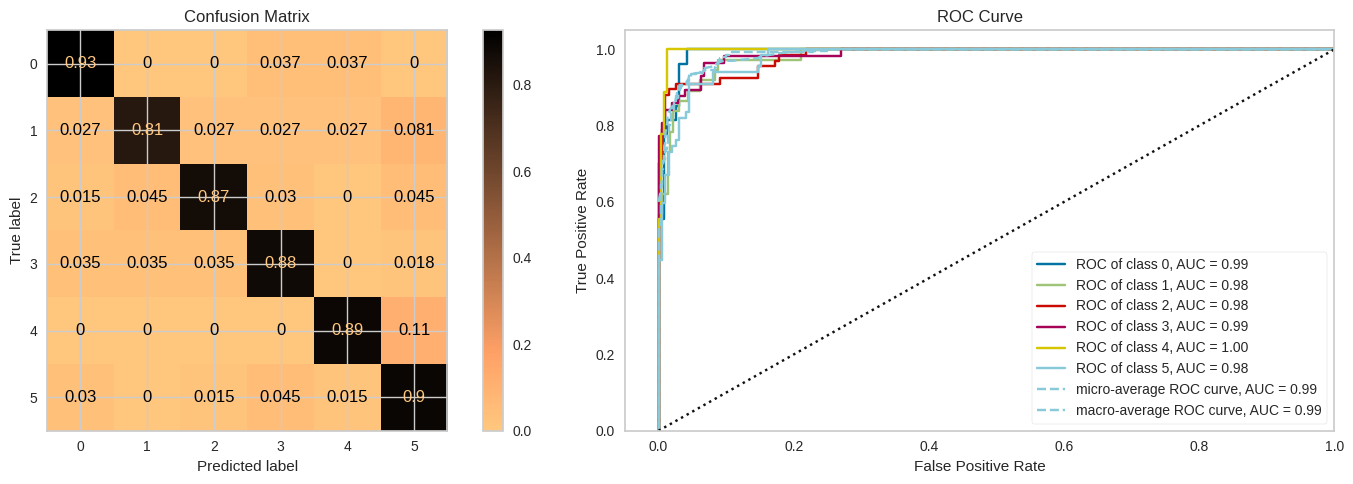

In [56]:
from sklearn.ensemble import RandomForestClassifier

X_feat_imp = X_train_trans.drop(columns=['remainder__name', 'remainder__id', 'cluster']).copy()
y_feat_imp = X_train_trans.cluster.copy()

X_feat_imp_train, X_feat_imp_test, y_feat_imp_train, y_feat_imp_test = train_test_split(
    X_feat_imp, y_feat_imp, train_size=.8)
# Random Forest
clf_rf = RandomForestClassifier(
    n_jobs=-1,
    criterion='entropy',
    min_samples_leaf=5,
    min_samples_split=6,
    class_weight='balanced_subsample',
)

model_report_multiclass(clf_rf,
                           X_feat_imp_train,
                           y_feat_imp_train,
                           X_feat_imp_test,
                           y_feat_imp_test,
                           show_train_report=False)


In [54]:
final_km = KMeans(
        n_clusters=6, init='random',
        n_init=10, max_iter=5000, 
        tol=1e-04, random_state=42
    )
X_train_trans['cluster'] = final_km.fit_predict(X_train_trans.drop(["remainname", "id"], axis=1))
X_train_trans['cluster'] = X_train_trans['cluster'].astype(np.int64)


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, verbose=1, perplexity=40, random_state=42, n_iter=5000)
tsne_results = tsne.fit_transform(X_train_trans.drop(["name", "id", "cluster"], axis=1))

/home/jenit/yes/envs/573/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jenit/yes/envs/573/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1319 samples in 0.002s...
[t-SNE] Computed neighbors for 1319 samples in 0.077s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1319
[t-SNE] Computed conditional probabilities for sample 1319 / 1319
[t-SNE] Mean sigma: 1.284871
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.380859
[t-SNE] KL divergence after 4450 iterations: 1.033633


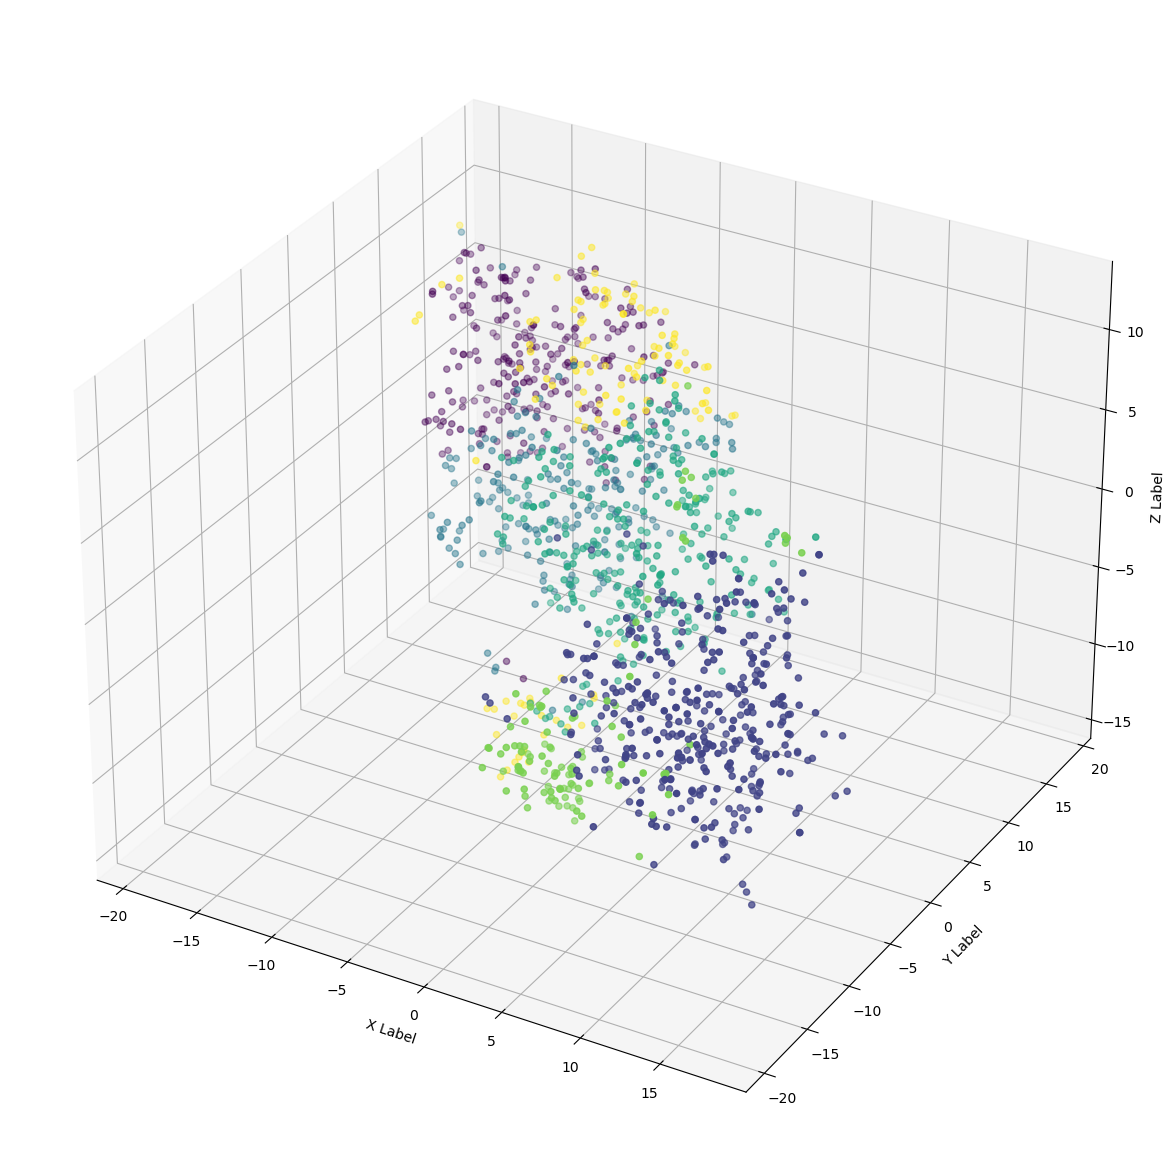

In [30]:
# X_tsne = X_train_trans.copy()
# X_tsne['tsne_0'] = tsne_results[:,0]
# X_tsne['tsne_1'] = tsne_results[:,1]

# chart = alt.Chart(X_tsne).mark_point().encode(
#     x="tsne_0",
#     y="tsne_1",
#     color=alt.Color(species', scale=alt.Scale(scheme='dark2'))
# ).properties(
#     width=750,
#     height=550
# )
# chart
n = 100
fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(111, projection='3d')
# ax = fig.add_subplot(111)

ax.scatter(tsne_results[:,0],
           tsne_results[:,1],
           tsne_results[:,2],
           c=X_train_trans['cluster'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
# ax.legend([0,1,2,3,4,5,6,7,8,9])

plt.show()


In [18]:
from scipy.spatial import distance

def get_distance(row, centers):
    return distance.cosine(row.drop(["id", "name", "cluster"]), centers[row['cluster']])

centers = final_km.cluster_centers_
X_distance = X_train_trans.copy()
X_distance["distance"] = X_distance.apply(get_distance, centers=centers, axis=1)

ValueError: operands could not be broadcast together with shapes (13,) (14,) 

In [ ]:
top_15 = X_distance.sort_values(['distance']).groupby("cluster").head(10).reset_index(drop=True)
top_15[top_15['cluster'] == 2]

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,key,mode,id,time_signature,name,cluster,distance
10,0.448893,-0.34249,0.316712,-0.091033,0.128527,-0.299708,0.657413,0.237564,-0.052683,-0.258031,7,0,0ESJlaM8CE1jRWaNtwSNj8,4,beibs in the trap,2,0.017008
11,-0.311242,0.347424,0.1547,-0.812217,-0.49176,-0.299708,-0.411009,-0.514696,0.453612,0.030756,7,1,0H8XeaJunhvpBdBFIYi6Sh,4,Deja Vu,2,0.019045
12,0.028656,-0.394668,-0.262823,-0.918473,0.098969,-0.299708,-0.740885,-0.615609,0.323066,0.3475,7,1,6eT7xZZlB2mwyzJ2sUKG6w,4,White Iverson,2,0.021458
13,0.257314,-0.139574,0.956199,-0.793378,0.153862,-0.299701,-0.557918,-0.52387,-0.323676,-0.096963,7,1,2shEeQzAAL3nnOXfB5pJXx,4,IMPORTED (with 6LACK),2,0.022432
14,0.146075,-0.000432,0.036223,0.037077,-0.463469,-0.296056,-0.484463,-0.468827,-1.039656,-0.603866,7,0,6SkHm6poyKfzV6kc9any8k,4,Suncity (feat. Empress Of),2,0.023424
15,0.98037,-0.672953,0.088324,-0.904909,-0.027706,-0.298805,-0.517852,-0.211957,-0.192144,0.174468,7,1,7MkysLvt3L8UFji2PceoFU,4,Molly (feat. Brendon Urie of Panic at the Disco),2,0.025034
16,0.232594,0.103925,0.469447,-0.845375,-0.481203,-0.299708,-0.390977,-0.482588,0.794523,-0.430537,6,1,45Egmo7icyopuzJN0oMEdk,4,Love Lies (with Normani),2,0.025715
17,0.751711,0.445983,0.615045,-0.714251,-0.395064,-0.299708,-0.484463,-0.161501,0.489745,-0.113581,7,0,2IePEfMAtqWS6rLXXFZIgI,4,"His & Hers (feat. Don Toliver, Lil Uzi Vert & ...",2,0.026658
18,-0.082584,0.347424,0.119728,-0.941835,-0.416177,-0.299623,-0.836375,-0.872479,0.219807,-0.128481,6,0,13d6t1p2Jg5a6DMUngy9Kj,4,head first - Young Bombs remix,2,0.026823
19,-0.051684,0.486566,0.450177,-0.271894,0.432547,-0.299708,-0.090483,0.095369,0.932043,-0.282766,5,0,52okn5MNA47tk87PeZJLEL,4,Let You Down,2,0.026874


In [ ]:
audio_analysis